In [132]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


#### **Disclaimer:**
Before I start I would like to give credit to Ken Jee for his video on this particular competition. It provided me a starter to tackle this challenge myself and a lot of my code will be based off what he explains in his video.

In [133]:
training = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

all_data = pd.concat([training,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Data Exploration

In [134]:
training.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [135]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [136]:
training.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [137]:
training.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [138]:
ticket_types = training['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else 'None')
ticket_type_counts = ticket_types.value_counts()
print(ticket_type_counts)

None          665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: Ticket, dtype: int64


In [139]:
cabin_counts = training['Cabin'].value_counts()
print(cabin_counts)

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64


In [140]:
cabin_data = training['Cabin'].str.split()

individual_cabins = []
for i in cabin_data:
    if isinstance(i, list):
        for j in i:
            individual_cabins.append(j[0])
    else:
        if isinstance(i, str):
            individual_cabins.append(i[0])
        else:
            individual_cabins.append('Unknown')


cabin_df = pd.DataFrame({'Cabin': individual_cabins})
cabin_counts_ind = cabin_df['Cabin'].value_counts()
print(cabin_counts_ind)

Unknown    687
C           71
B           64
D           34
E           33
A           15
F           13
G            7
T            1
Name: Cabin, dtype: int64


#### Something I like to do while exploring data is plotting as many graphs as i can to check if there is any correlation or any trends to identify. Also it just looks pretty.

In [141]:
plt.style.use("dark_background")

In [142]:
cabin_df = cabin_df[~cabin_df.index.duplicated(keep='first')]

In [143]:
cabin_df['Survived'] = training['Survived']
cabin_survival_rate = cabin_df.groupby('Cabin')['Survived'].mean()

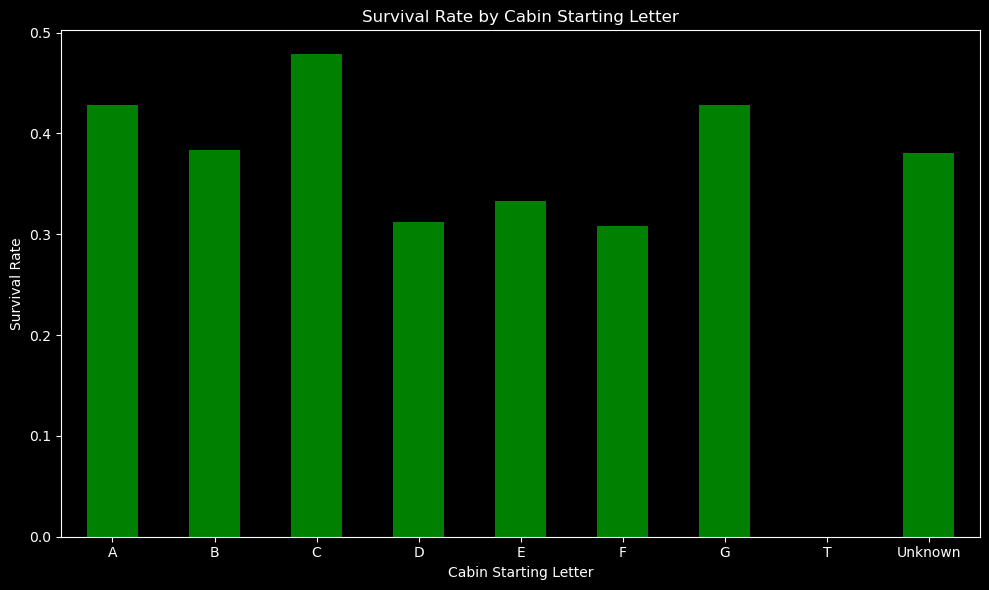

In [144]:
plt.figure(figsize=(10, 6))
cabin_survival_rate.plot(kind='bar', color='green')
plt.title('Survival Rate by Cabin Starting Letter')
plt.xlabel('Cabin Starting Letter')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

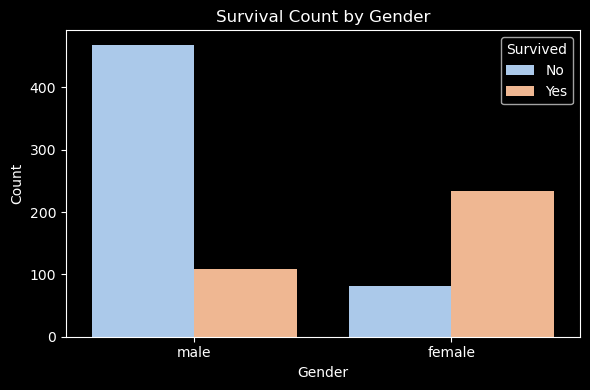

In [145]:
plt.figure(figsize=(6, 4))
sns.countplot(data=training, x="Sex", hue="Survived", palette="pastel")
plt.title("Survival Count by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

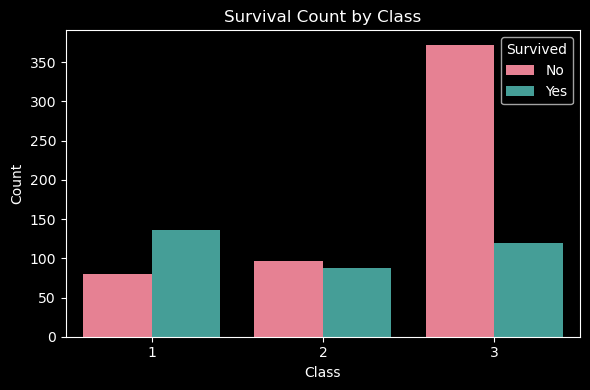

In [146]:
plt.figure(figsize=(6, 4))
sns.countplot(data=training, x="Pclass", hue="Survived", palette="husl")
plt.title("Survival Count by Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

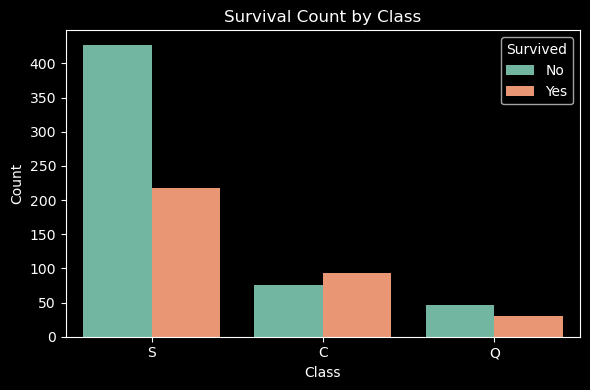

In [147]:
plt.figure(figsize=(6, 4))
sns.countplot(data=training, x="Embarked", hue="Survived", palette="Set2")
plt.title("Survival Count by Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

In [148]:
training['FamilySize'] = training['SibSp'] + training['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

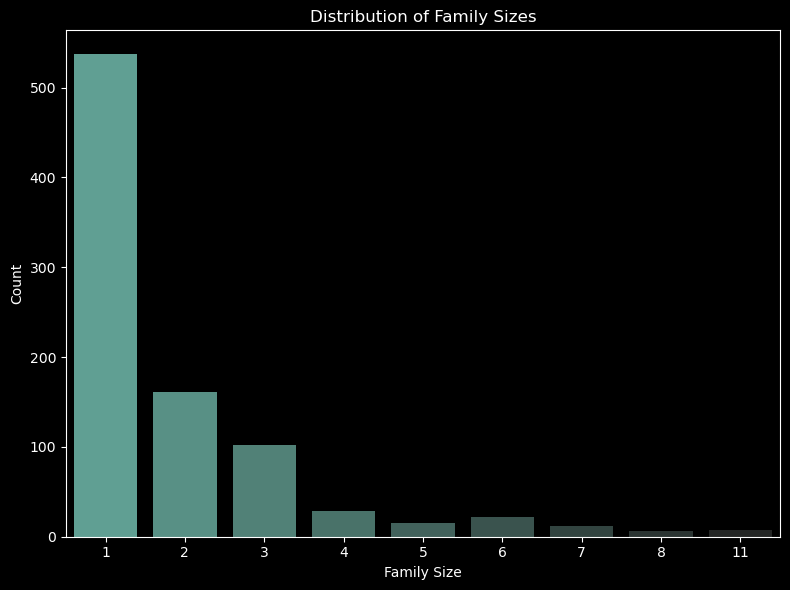

In [149]:
plt.figure(figsize=(8, 6))
sns.countplot(data=training, x="FamilySize", palette="dark:#5A9_r")
plt.title("Distribution of Family Sizes")
plt.xlabel("Family Size")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [150]:
family_survival = training.groupby('FamilySize')['Survived'].mean()

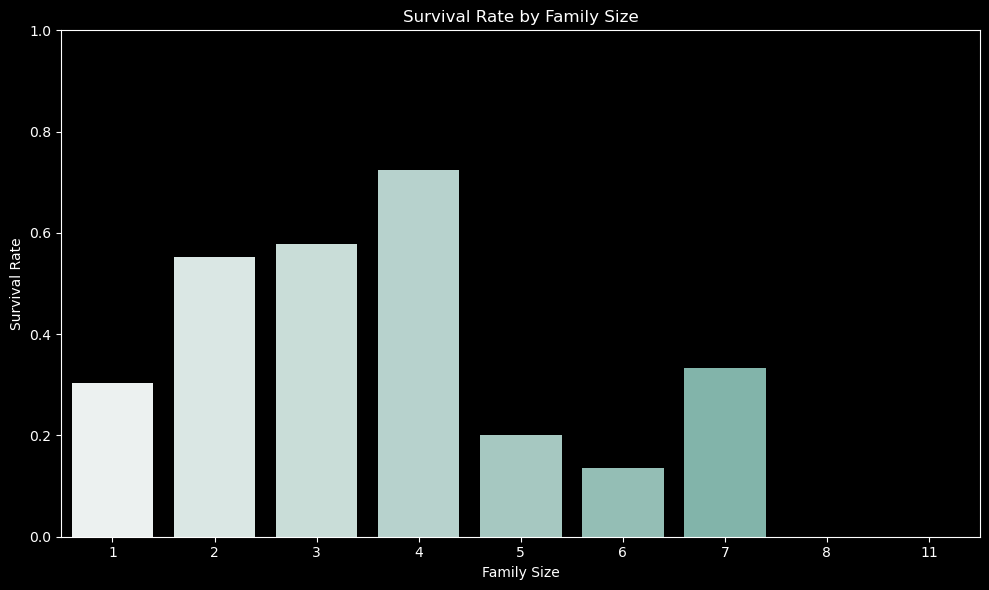

In [151]:
plt.figure(figsize=(10, 6))
sns.barplot(x=family_survival.index, y=family_survival.values, palette="light:#5A9")
plt.title("Survival Rate by Family Size")
plt.xlabel("Family Size")
plt.ylabel("Survival Rate")
plt.ylim(0, 1)  # Set y-axis limit to ensure survival rate is within [0, 1]
plt.tight_layout()
plt.show()

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

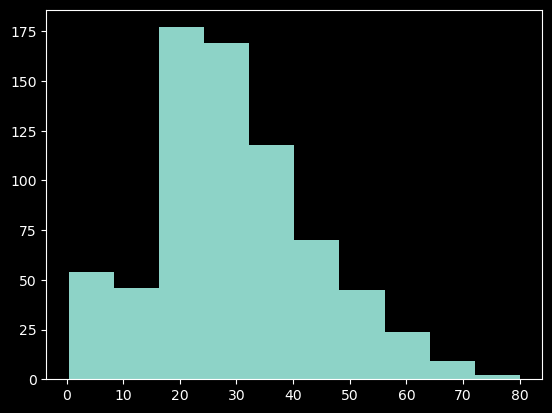

In [152]:
plt.hist(training['Age'])

In [153]:
fare_bins = pd.qcut(training['Fare'], q=8)
fare_survival_rate = training.groupby(fare_bins)['Survived'].mean()

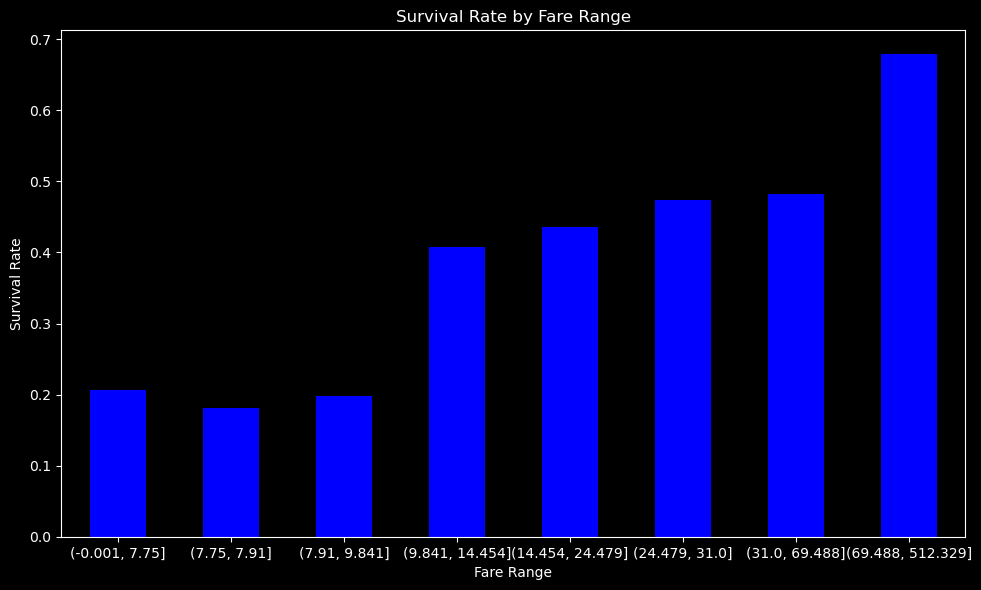

In [154]:
plt.figure(figsize=(10, 6))
fare_survival_rate.plot(kind='bar', color='blue')
plt.title('Survival Rate by Fare Range')
plt.xlabel('Fare Range')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Engineering and PreProcessing

In [155]:
training.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2


In [156]:
data_use = training

In [157]:
data_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [158]:
data_use.drop(['Ticket', 'Name'], axis=1)
data_use['Age'] = data_use['Age'].interpolate()
data_use['Embarked'] = data_use['Embarked'].dropna()
data_use['Cabin'] = data_use['Cabin'].fillna('U')

test.drop(['Ticket', 'Name'], axis=1)
test['Age'] = test['Age'].interpolate()
test['Embarked'] = test['Embarked'].dropna()
test['Cabin'] = test['Cabin'].fillna('U')

In [159]:
data_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [160]:
fare_bins = [0, 8, 15, 31, float('inf')] 
fare_labels = ['Low', 'Medium', 'High', 'Very High']
data_use['FareType'] = pd.cut(data_use['Fare'], bins=fare_bins, labels=fare_labels)
all_dummies = pd.get_dummies(data_use[['Pclass','Sex','Age','SibSp','Parch','FareType','Embarked', 'FamilySize', 'Survived']])

test['FareType'] = pd.cut(test['Fare'], bins=fare_bins, labels=fare_labels)
test_final = pd.get_dummies(test[['Pclass','Sex','Age','SibSp','Parch','FareType','Embarked', 'FamilySize']])

In [161]:
all_dummies.head(10)

,Pclass,Age,SibSp,Parch,FamilySize,Survived,Sex_female,Sex_male,FareType_Low,FareType_Medium,FareType_High,FareType_Very High,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,2,0,0,1,1,0,0,0,0,0,1
1,1,38.0,1,0,2,1,1,0,0,0,0,1,1,0,0
2,3,26.0,0,0,1,1,1,0,1,0,0,0,0,0,1
3,1,35.0,1,0,2,1,1,0,0,0,0,1,0,0,1
4,3,35.0,0,0,1,0,0,1,0,1,0,0,0,0,1
5,3,44.5,0,0,1,0,0,1,0,1,0,0,0,1,0
6,1,54.0,0,0,1,0,0,1,0,0,0,1,0,0,1
7,3,2.0,3,1,5,0,0,1,0,0,1,0,0,0,1
8,3,27.0,0,2,3,1,1,0,0,1,0,0,0,0,1
9,2,14.0,1,0,2,1,1,0,0,0,1,0,1,0,0


In [162]:
data_train, data_test = train_test_split(all_dummies, test_size=0.2)
X_final = all_dummies.drop(['Survived'], axis=1)
y_final = all_dummies['Survived']

In [163]:
X_train = data_train.drop(['Survived'], axis=1)
X_test = data_test.drop(['Survived'], axis=1)
y_train = data_train['Survived']
y_test = data_test['Survived']

## Model Building

In [164]:
LogReg = LogisticRegression(max_iter = 1000)
cv = cross_val_score(LogReg,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.83216783 0.81118881 0.75352113 0.83098592 0.82394366]
0.8103614695163991


In [165]:
DecTree = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(DecTree,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76923077 0.79020979 0.75352113 0.79577465 0.77464789]
0.7766768442824781


In [166]:
TreeClass = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(TreeClass,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76923077 0.79020979 0.75352113 0.79577465 0.77464789]
0.7766768442824781


In [167]:
KNeigh = KNeighborsClassifier()
cv = cross_val_score(KNeigh,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.74125874 0.70629371 0.78873239 0.80985915 0.73943662]
0.7571161233133064


In [168]:
RandFor = RandomForestClassifier(random_state = 1)
cv = cross_val_score(RandFor,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.75524476 0.81818182 0.73943662 0.78873239 0.78169014]
0.7766571456712301


In [169]:
XGB = XGBClassifier(random_state =1)
cv = cross_val_score(XGB,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79020979 0.8041958  0.79577465 0.83802817 0.79577465]
0.8047966118388654


In [170]:
voting_clf = VotingClassifier(estimators = [('LogReg',LogReg),('DecTree',DecTree),('TreeClass',TreeClass),('KNeigh',KNeigh),('RandFor',RandFor),('XGB',XGB)], voting = 'soft')
cv = cross_val_score(voting_clf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76923077 0.81818182 0.78169014 0.8028169  0.77464789]
0.7893135033980104


In [171]:
voting_clf2 = VotingClassifier(estimators = [('LogReg',LogReg), ('XGB',XGB)], voting = 'soft')
cv = cross_val_score(voting_clf2,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.82517483 0.84615385 0.83098592 0.86619718 0.83098592]
0.8398995370826355


In [172]:
voting_clf2.fit(X_train,y_train)

VotingClassifier(estimators=[('LogReg', LogisticRegression(max_iter=1000)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=1, ...))],
                 voting='soft')

In [173]:
y_pred = voting_clf2.predict(test_final).astype(int)

In [175]:
final_data = {'PassengerId': test.PassengerId, 'Survived': y_pred}
submission = pd.DataFrame(data=final_data)
submission.to_csv('submission.csv', index =False)